In [1]:
import math
import random
import csv
import sys
import operator
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from shapely.geometry import Polygon, Point

import cvxpy as cp

import keras
from keras import layers
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.special import comb, perm
import time

In [2]:
# !pip install Ipython --upgrade
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Mount Google Drive Folder

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
rootPath = '/content/drive/Shareddrives/KW phase1 repo'

Mounted at /content/drive


In [ ]:
import sys
sys.path.append(rootPath+'/package')
from utils.env_pca import env
from model.uav import UAV

## AE 

### Read Rawdata from csv



In [ ]:
socpResultsDatas = []
div = 200
for j in range(env.N_ngps):
  with open(rootPath+"/datas/anomalyNewSDPResult/0811_MDS/test_position{}_pickerror0_deviation{}_100.csv".format(j,div), "r") as _csv:
    csvReader = list (csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    socpResultsDatas.append(csvReader)

### Read UAV Position

In [ ]:
f = open(rootPath+"/datas/uavPosition/300_0706/done_deviation/{}/UAVsSamples.pkl".format(div), "rb")
UAVsSamples = pickle.load(f)
print(UAVsSamples)

{0: {0: <model.uav.UAV object at 0x7f0d1a26df10>, 1: <model.uav.UAV object at 0x7f0d7eb45c50>, 2: <model.uav.UAV object at 0x7f0d7eb455d0>, 3: <model.uav.UAV object at 0x7f0d7eb45f90>, 4: <model.uav.UAV object at 0x7f0d7eb45610>, 5: <model.uav.UAV object at 0x7f0d7eb45d90>, 6: <model.uav.UAV object at 0x7f0d7eb45910>, 7: <model.uav.UAV object at 0x7f0d7eb45bd0>, 8: <model.uav.UAV object at 0x7f0d7eb458d0>, 9: <model.uav.UAV object at 0x7f0d7eb45510>, 10: <model.uav.UAV object at 0x7f0d7eb45390>, 11: <model.uav.UAV object at 0x7f0d7eb45850>, 12: <model.uav.UAV object at 0x7f0d7eb45150>, 13: <model.uav.UAV object at 0x7f0d7eb45090>, 14: <model.uav.UAV object at 0x7f0d7eb454d0>, 15: <model.uav.UAV object at 0x7f0d7eb45890>}, 1: {0: <model.uav.UAV object at 0x7f0d7eb45f10>, 1: <model.uav.UAV object at 0x7f0d7eb45b90>, 2: <model.uav.UAV object at 0x7f0d7eb45d10>, 3: <model.uav.UAV object at 0x7f0d7eb45b10>, 4: <model.uav.UAV object at 0x7f0d7eb45210>, 5: <model.uav.UAV object at 0x7f0d7eb45

In [ ]:
assert(np.array(socpResultsDatas).shape[0] == env.N_ngps)
assert(np.array(socpResultsDatas).shape[2] == env.DIMENSION)
groupSize =0
for i in np.arange(env.groupSizeFrom,env.N_ngps+1,1):
  groupSize += comb(env.N_ngps,i)
groupSize = int(groupSize)
print(np.array(socpResultsDatas).shape, env.SAMPLES, groupSize)
assert(np.array(socpResultsDatas).shape[1]//env.SAMPLES == groupSize)

(8, 9300, 2) 100 93


### Loading sample from data

In [ ]:
rawDatas = []
ReadSampleSize = env.LOAD_SAMPLES_FOR_AE
for i in range(env.N_ngps):
  temp = []
  for j in range(ReadSampleSize):
    temp.append(socpResultsDatas[i][j*groupSize : j*groupSize+groupSize])
  rawDatas.append(temp)

In [ ]:
assert(np.array(rawDatas).shape[1] ==  env.LOAD_SAMPLES_FOR_AE)

In [ ]:
_anchorSamples = []
anchorSamples = []
for sample in range(ReadSampleSize):
  temp = []
  for id, uav in UAVsSamples[sample].items():
    if not uav.observedPosition == None:
      temp.append([uav.observedPosition for i in range(groupSize)])
  _anchorSamples.append(temp)
for i in range(env.N_gps):
  temp = []
  for sample in range(ReadSampleSize):
    temp.append(_anchorSamples[sample][i])
  anchorSamples.append(temp)

In [ ]:
# list(map(lambda i: rawDatas.append(anchorSamples[i]), range(env.N_gps)))
# None
# assert(np.array(rawDatas).shape[0] == env.N)

In [ ]:
np.array(rawDatas).shape

(8, 100, 93, 2)

### Devide Test and Training set


In [ ]:
testingSampleSize = int(( ReadSampleSize * env.TEST_PERCENTAGE )//1)
if testingSampleSize == 0:
  testingSampleSize = 1
traningSampleSize = int(ReadSampleSize-testingSampleSize)
rawTrainingData = list(map( lambda item: item[:-testingSampleSize], rawDatas))
rawTestingData =  list(map( lambda item: item[traningSampleSize:], rawDatas))

In [ ]:
dualGroupingTrainingData = []
dualGroupingTestingData = []
def dualFunc(X,i,j): 
    temp = []
    for index_1, e1 in enumerate(X[i][j]):
      for index_2, e2 in enumerate(X[i][j]):
        if not index_1 == index_2:
          temp.append([e1, e2])
    return temp

rawTrainingDataShape = np.array(rawTrainingData).shape
rawTestingDataShape = np.array(rawTestingData).shape
for i in range(rawTrainingDataShape[0]):
  trainingS = list(map(lambda j: dualFunc(rawTrainingData,i,j),np.arange(0,rawTrainingDataShape[1])))
  testingS = list(map(lambda j: dualFunc(rawTestingData,i,j),np.arange(0,rawTestingDataShape[1])))
  dualGroupingTrainingData.append(trainingS)
  dualGroupingTestingData.append(testingS)

_trainingDataShape = np.array(dualGroupingTrainingData).shape
_testingDataShape= np.array(dualGroupingTestingData).shape
_reshapeTrainingData = []
_reshapeTestingData = []
def swapFunc(j,X,shapeOfX,targetReformSlice): 
  for sample in range(shapeOfX[1]): #sample
    temp = []
    for i in range(shapeOfX[0]):
      temp.append(X[i][sample][j])
    targetReformSlice.append(temp) 
list(map(lambda _sample: swapFunc(_sample,dualGroupingTrainingData,_trainingDataShape,_reshapeTrainingData), range(_trainingDataShape[2]))) #8556
list(map(lambda _sample: swapFunc(_sample,dualGroupingTestingData,_testingDataShape,_reshapeTestingData), range(_testingDataShape[2])))
print("")
VAETrainingData = np.array(_reshapeTrainingData).reshape(len(_reshapeTrainingData), np.prod(np.array(_reshapeTrainingData).shape[1:]))
VAETestingData = np.array(_reshapeTestingData).reshape(len(_reshapeTestingData), np.prod(np.array(_reshapeTestingData).shape[1:]))

In [ ]:
shapeOfRawTrainingData = np.array(rawTrainingData).shape
assert(np.array(VAETrainingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)
assert(np.array(VAETestingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)

### normorlization


In [ ]:
data_min = 0
data_max = max(max(env.X_RANGE,env.Y_RANGE),env.Z_RANGE)
print(data_min, data_max)

normalizeVAETrainingData = (VAETrainingData-data_min)/(data_max - data_min)
normalizeVAETrainingData = normalizeVAETrainingData.astype('float32')

normalizeVAETestingData = (VAETestingData-data_min)/(data_max - data_min)
normalizeVAETestingData = normalizeVAETestingData.astype('float32')

0 1000


In [ ]:
X_train = normalizeVAETrainingData
y_train = normalizeVAETestingData
# X_train = VAETrainingData.astype('float32')
# y_train = VAETestingData.astype('float32')

In [ ]:
print(X_train)
print(y_train)

[[-0.21208903 -0.21208903 -0.04737617 ... -0.19742933 -0.57849926
  -0.57849926]
 [-0.10086426 -0.10086426  0.21928924 ...  0.5950231  -0.33583078
  -0.33583078]
 [-0.5912485  -0.5912485   0.38490433 ...  0.40585026 -0.69717675
  -0.69717675]
 ...
 [ 0.86260587  0.86260587 -0.04868534 ... -0.32286653 -0.5020125
  -0.5020125 ]
 [-0.24072537 -0.24072537  0.04292218 ...  0.22909604  0.8236812
   0.8236812 ]
 [ 0.17585246  0.17585246 -0.6451515  ... -0.44560403  0.8106477
   0.8106477 ]]
[[ 0.4622577   0.4622577   0.10700115 ... -0.68243295 -0.64738405
  -0.64738405]
 [ 0.31554925  0.31554925  0.3047803  ... -0.56540865 -0.581267
  -0.581267  ]
 [ 0.5291338   0.5291338  -0.41890016 ...  0.43276182  0.50564474
   0.50564474]
 ...
 [ 0.40151364  0.40151364  0.00354131 ... -0.2659431  -1.0938838
  -1.0938838 ]
 [ 0.24455293  0.24455293 -0.05487414 ...  0.12230366 -0.82975173
  -0.82975173]
 [ 0.5280563   0.5280563  -0.06035717 ...  0.673397   -0.61684024
  -0.61684024]]


In [ ]:
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(770040, 32)
(85560, 32)


In [ ]:
print(_reshapeTrainingData[0])
print(normalizeVAETrainingData[0])

[[[-212.08902900152884, -212.08902900152884], [-47.37616685546763, -47.37616685546763]], [[471.34841029254346, 471.34841029254346], [381.6407279158086, 381.6407279158086]], [[970.3479024982164, 970.3479024982164], [967.5483330480181, 967.5483330480181]], [[110.44859222951922, 110.44859222951922], [-71.19498347884004, -71.19498347884004]], [[-391.7178242339925, -391.7178242339925], [504.8799159950791, 504.8799159950791]], [[-197.42932940852882, -197.42932940852882], [-578.4992755415326, -578.4992755415326]], [[-553.4793929677014, -553.4793929677014], [-578.4992755415327, -578.4992755415327]], [[-197.42932940852813, -197.42932940852813], [-578.4992755415327, -578.4992755415327]]]
[-0.21208903 -0.21208903 -0.04737617 -0.04737617  0.4713484   0.4713484
  0.38164073  0.38164073  0.9703479   0.9703479   0.9675483   0.9675483
  0.11044859  0.11044859 -0.07119498 -0.07119498 -0.39171782 -0.39171782
  0.5048799   0.5048799  -0.19742933 -0.19742933 -0.57849926 -0.57849926
 -0.5534794  -0.5534794

In [ ]:
batch_size = env.batch_size
latent_dim = env.latent_dim
intermediate_dim =env.intermediate_dim
final_dim = env.final_dim
epochs = env.epochs
epsilon_std = env.epsilon_std

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
originalShape = X_train.shape[1:]
originalDimaintion = np.prod(originalShape)
print(originalShape)
in_layer = Input(shape=originalShape)
x = Flatten()(in_layer)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(originalDimaintion, activation='sigmoid')

f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_img = Reshape(originalShape)(x_decoded_mean)

# instantiate VAE model
vae = Model(in_layer, x_decoded_img)

# Compute VAE loss
xent_loss = originalDimaintion * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.summary()

(32,)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 32)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           2112        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
________________________________________________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = vae.fit(X_train, X_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        shuffle=True,
        validation_data=(y_train, y_train),
        callbacks=[callback],
        ).history

Epoch 1/100
94/94 [==============================] - 4s 29ms/step - loss: 21.4773 - val_loss: 19.0891
Epoch 2/100
94/94 [==============================] - 2s 27ms/step - loss: 16.6736 - val_loss: 14.0285
Epoch 3/100
94/94 [==============================] - 3s 27ms/step - loss: 11.2136 - val_loss: 8.3369
Epoch 4/100
94/94 [==============================] - 3s 27ms/step - loss: 6.2047 - val_loss: 4.4329
Epoch 5/100
94/94 [==============================] - 3s 27ms/step - loss: 3.3392 - val_loss: 2.3270
Epoch 6/100
94/94 [==============================] - 3s 27ms/step - loss: 1.0687 - val_loss: -1.0787
Epoch 7/100
94/94 [==============================] - 3s 27ms/step - loss: -17.4288 - val_loss: -62.4345
Epoch 8/100
94/94 [==============================] - 3s 27ms/step - loss: -300.6169 - val_loss: -701.9897
Epoch 9/100
94/94 [==============================] - 3s 27ms/step - loss: -1710.5170 - val_loss: -3097.0947
Epoch 10/100
94/94 [==============================] - 3s 27ms/step - loss: -

In [ ]:
vae.save(rootPath+"/datas/trainingModel/VAENoanchorMDSModel_300sample_8UAV_8uUAV_div{}".format(div))

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/KW phase1 repo/datas/trainingModel/VAENoanchorMDSModel_300sample_8UAV_8uUAV_div200/assets


In [ ]:
# modelPath = rootPath+"/datas/trainingModel/VAENoanchorModel_300sample_8UAV_8uUAV_div20"
# loadVae = keras.models.load_model(modelPath, custom_objects={'latent_dim': env.latent_dim, 'epsilon_std': env.epsilon_std})

In [ ]:
# vae = loadVae

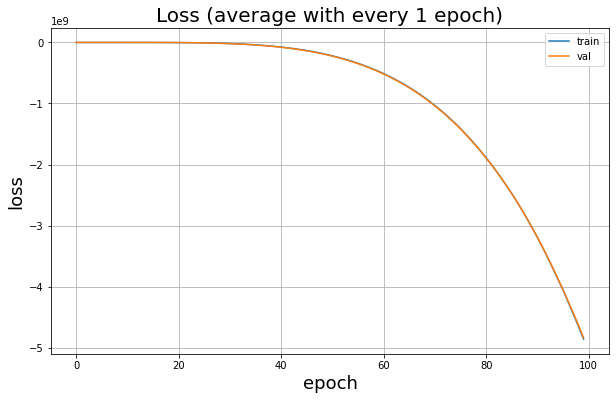

In [ ]:
fig = plt.figure(figsize=(10,6))
acc = []
valAcc = []
step = 1
for i in range(len(history['loss'])//step):
  acc.append(np.mean(history['loss'][i:i+step:1]))
  valAcc.append(np.mean(history['val_loss'][i:i+step:1]))

plt.plot(acc)
plt.plot(valAcc)
plt.title('Loss (average with every {} epoch)'.format(step), fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.grid()
plt.legend(['train', 'val'], loc='upper right')

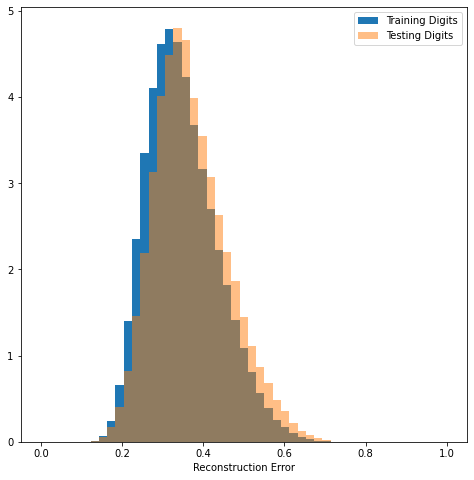

In [ ]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), axis=1)
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(X_train), bins = np.linspace(0, 1, 50), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(y_train), bins = np.linspace(0, 1, 50), label = 'Testing Digits', density = True, alpha = 0.5)
# ax1.hist(model_mse(anomaly_data), bins = np.linspace(0, 1, 50), label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

In [ ]:
trainMean = np.mean(model_mse(X_train))
trainStd = np.std(model_mse(X_train))
# testMean = np.mean(model_mse(y_train))
# testStd = np.std(model_mse(y_train))
# anomalyMean = np.mean(model_mse(anomaly_data))
# anomalyStd = np.std(model_mse(anomaly_data))
print(trainMean,trainStd)
# print(trainStd,testStd)
# print(model_mse(X_train).shape)

0.3496029 0.0869234


In [ ]:
# div 10
# 0.2853614 0.07227975

# div 20
# 0.30043313 0.07408192

# div 30
# 0.2955338 0.10154206

# div 40
# 0.32650992 0.085954204

# div 50
# 0.28222504 0.0875005

# div 60
# 0.31428796 0.0867091

# div 70
# 0.31984645 0.08283562

# div 80
# 0.31552613 0.07904724

# div 90
# 0.29458016 0.07781351

# div 100
# 0.29828808 0.064164646

# div 200
# 0.3496029 0.0869234

# div 300
# 0.28518927 0.09565228

# div 350
# 0.3197248 0.11527189